/var/folders/21/0n_gt26x0cl9hz7mf2yx2n9w0000gn/T/ipykernel_2915/1133424138.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.groupby(pd.Grouper(key='Date', freq='M'))['Total Prostate MRI'].sum().reset_index()


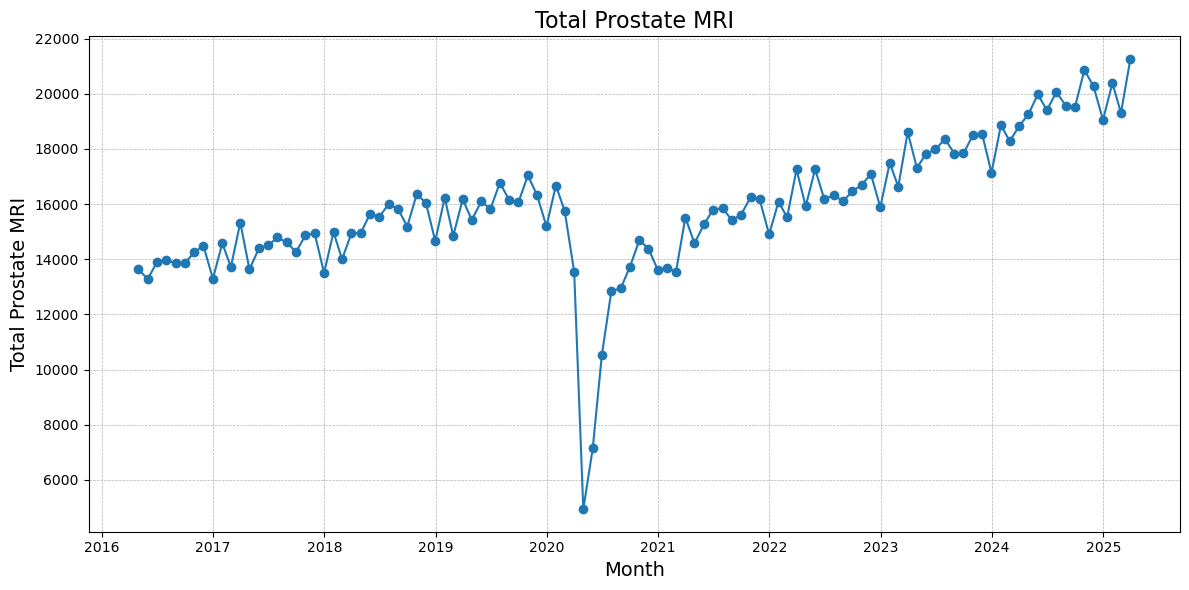

In [1]:

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt


# Load the CSV file
file_path = "TotalMRI_Timeseries.csv"
df = pd.read_csv(file_path)


# Data cleaning

# Strip whitespace from column names and 'Date' values
df.columns = df.columns.str.strip()
df['Date'] = df['Date'].str.strip()

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

# Ensure 'Total Prostate MRI' is numeric
df['Total Prostate MRI'] = pd.to_numeric(df['Total Prostate MRI'], errors='coerce')

# Group by Year-Month
df_monthly = df.groupby(pd.Grouper(key='Date', freq='M'))['Total Prostate MRI'].sum().reset_index()

# Plot monthly time series

plt.figure(figsize=(12, 6))
plt.plot(df_monthly['Date'], df_monthly['Total Prostate MRI'], marker='o', linestyle='-')

# Add labels and title
plt.title("Total Prostate MRI", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Prostate MRI", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()


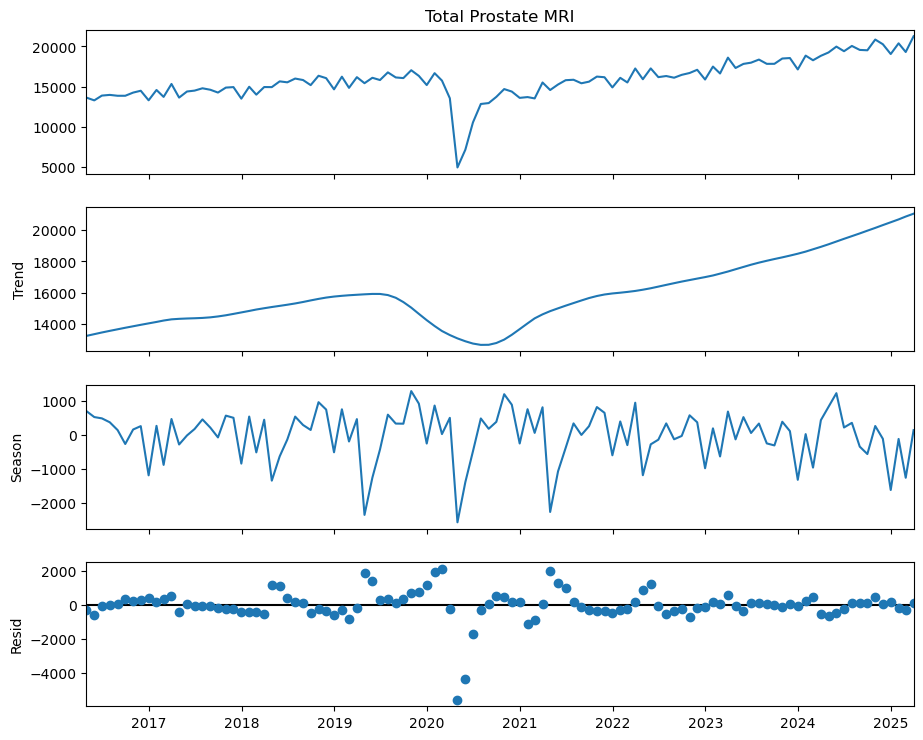

In [3]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Ensure Date is datetime and sorted
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
df_monthly = df_monthly.sort_values('Date')

# Create time series
ts = df_monthly.set_index('Date')['Total Prostate MRI']

# Run STL decomposition (period=12 for monthly data)
stl = STL(ts, period=12)
result = stl.fit()

# Plot the decomposition
fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()


In [5]:
from statsmodels.tsa.stattools import adfuller

# Run the Augmented Dickey-Fuller test
adf_result = adfuller(ts)

# Display the results
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# Interpretation
if adf_result[1] < 0.05:
    print("The series is stationary (reject H0).")
else:
    print("The series is NOT stationary (fail to reject H0).")


ADF Statistic: -0.0760
p-value: 0.9518
Critical Value (1%): -3.5019
Critical Value (5%): -2.8928
Critical Value (10%): -2.5835
The series is NOT stationary (fail to reject H0).


In [7]:
from statsmodels.tsa.stattools import adfuller

# First-order differencing to remove trend
ts_diff = ts.diff().dropna()

# Run ADF test on differenced series
adf_result_diff = adfuller(ts_diff)

print(f"ADF Statistic (1st diff): {adf_result_diff[0]:.4f}")
print(f"p-value: {adf_result_diff[1]:.4f}")
for key, value in adf_result_diff[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# Interpretation
if adf_result_diff[1] < 0.05:
    print("The differenced series is stationary (reject H0).")
else:
    print("The differenced series is NOT stationary (fail to reject H0).")


ADF Statistic (1st diff): -3.7855
p-value: 0.0031
Critical Value (1%): -3.5019
Critical Value (5%): -2.8928
Critical Value (10%): -2.5835
The differenced series is stationary (reject H0).


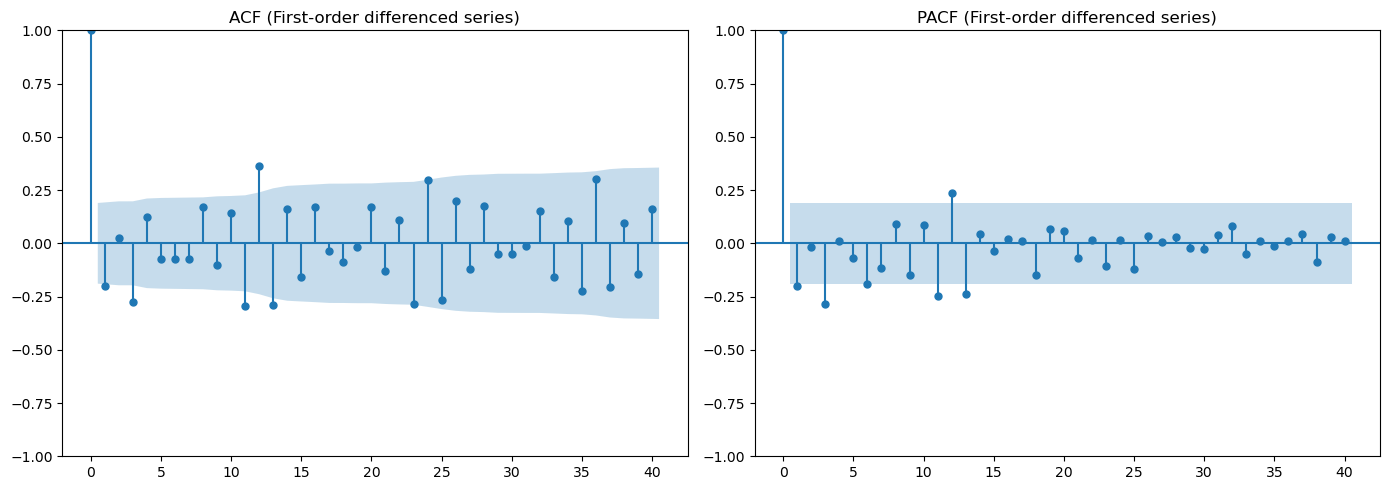

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Autocorrelation Function
plot_acf(ts_diff, lags=40, ax=axes[0])
axes[0].set_title("ACF (First-order differenced series)")

# Partial Autocorrelation Function
plot_pacf(ts_diff, lags=40, ax=axes[1], method='ywm')
axes[1].set_title("PACF (First-order differenced series)")

plt.tight_layout()
plt.show()


In [11]:
from pmdarima import auto_arima

# Run auto_arima with seasonal search
model = auto_arima(
    ts,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=1,                    
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    D=1,                     # allow seasonal differencing
    m=12,                    # monthly seasonality
    seasonal=True,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

# Summary of the best model
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1661.231, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1642.449, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1635.252, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1659.662, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1641.337, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1635.710, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1636.596, Time=0.28 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1634.682, Time=0.19 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1659.518, Time=0.02 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=1

In [13]:
# keep the last 12 months for testing
test_size = 12  

# Ensure ts is sorted and has a DateTimeIndex
ts = ts.sort_index()

# Split into train and test sets
train = ts.iloc[:-test_size]
test = ts.iloc[-test_size:]

print(f"Train period: {train.index.min().date()} to {train.index.max().date()}")
print(f"Test period: {test.index.min().date()} to {test.index.max().date()}")

# Quick check of sizes
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train period: 2016-04-30 to 2024-03-31
Test period: 2024-04-30 to 2025-03-31
Train size: 96, Test size: 12


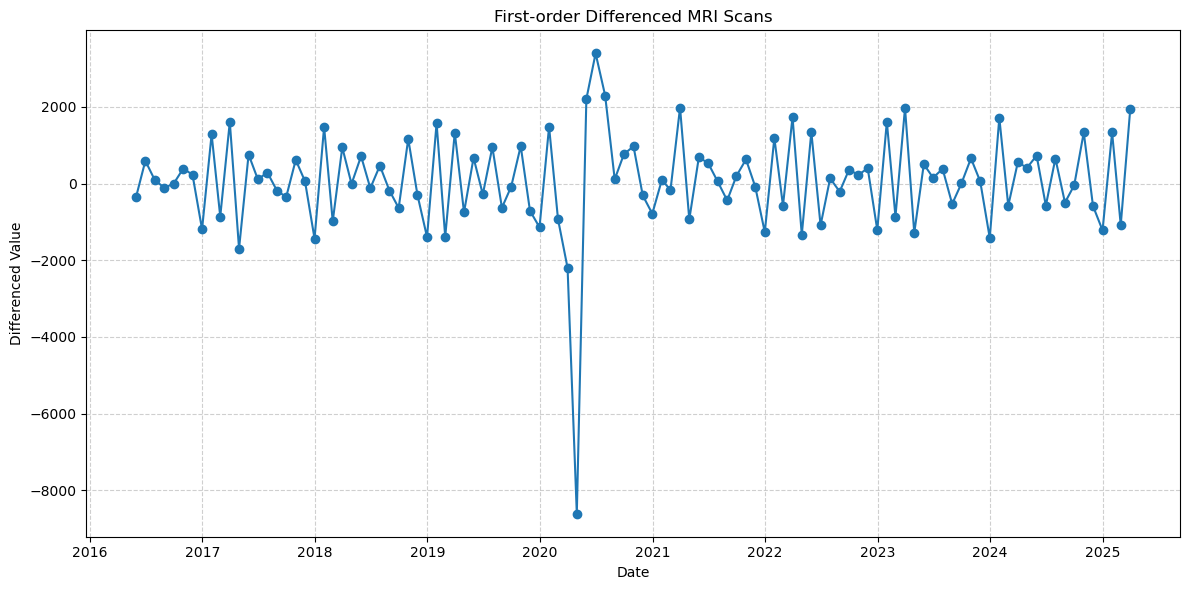

In [15]:
import matplotlib.pyplot as plt

# First-order differencing
ts_diff = ts.diff().dropna()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ts_diff, marker='o', linestyle='-')
plt.title('First-order Differenced MRI Scans')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Outlier months replaced: [datetime.date(2020, 4, 30)]


/var/folders/21/0n_gt26x0cl9hz7mf2yx2n9w0000gn/T/ipykernel_2915/759494811.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.sort_index().asfreq('M')  # set/confirm monthly freq to avoid warnings


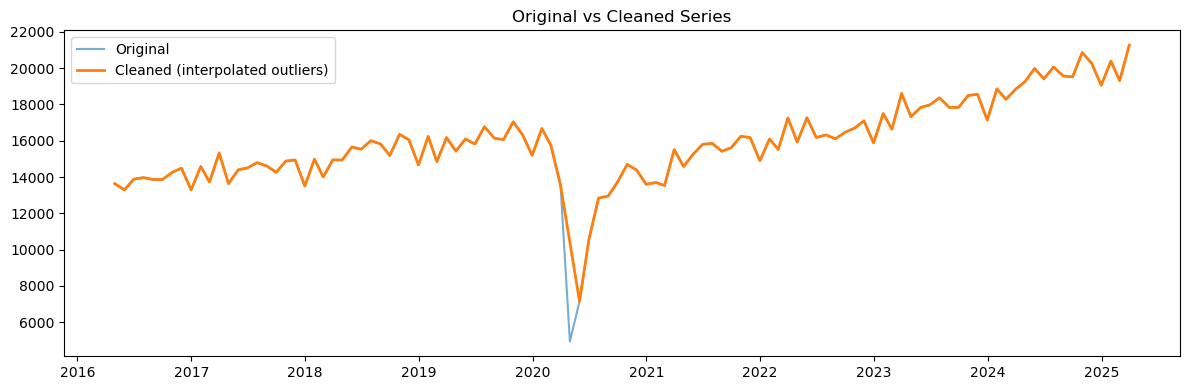

Train: 2016-04-30 → 2024-03-31
Test:  2024-04-30  → 2025-03-31
                                     SARIMAX Results                                      
Dep. Variable:                 Total Prostate MRI   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -693.375
Date:                            Sat, 16 Aug 2025   AIC                           1396.750
Time:                                    18:13:10   BIC                           1408.845
Sample:                                04-30-2016   HQIC                          1401.609
                                     - 03-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9971      0.083    -11.951      0.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


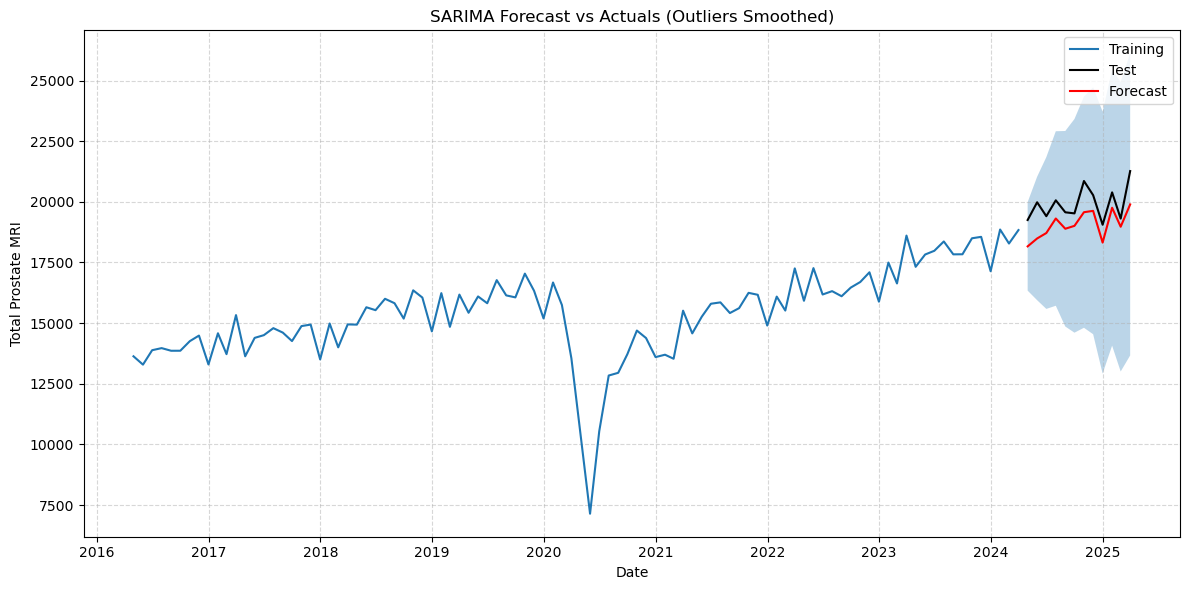

In [17]:

# ensure monthly frequency and sort

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

ts = ts.sort_index().asfreq('M')  # set/confirm monthly freq to avoid warnings


# Detect extreme outliers in the *differenced* series using
# a robust z-score (MAD). Then smooth those months by
# linear interpolation in the ORIGINAL series.

diff = ts.diff()

# Robust z-score: 0.6745 * (x - median) / MAD
med = diff.median()
mad = (diff - med).abs().median()
robust_z = 0.6745 * (diff - med) / (mad if mad != 0 else 1)

# Threshold: flag very extreme moves (e.g., |z| > 5)
outlier_idx = robust_z.index[robust_z.abs() > 5]

# Create a cleaned copy and interpolate only the flagged months
ts_clean = ts.copy()
ts_clean.loc[outlier_idx] = np.nan
ts_clean = ts_clean.interpolate(method='time')

print(f"Outlier months replaced: {list(outlier_idx.date)}")

# (Optional) Quick visual check
plt.figure(figsize=(12,4))
plt.plot(ts, label='Original', alpha=0.6)
plt.plot(ts_clean, label='Cleaned (interpolated outliers)', linewidth=2)
plt.title('Original vs Cleaned Series')
plt.legend()
plt.tight_layout()
plt.show()

# Train / Test split (last 12 months as test)

test_size = 12
train = ts_clean.iloc[:-test_size]
test  = ts_clean.iloc[-test_size:]

print(f"Train: {train.index.min().date()} → {train.index.max().date()}")
print(f"Test:  {test.index.min().date()}  → {test.index.max().date()}")

#  Fit a simpler, stable seasonal ARIMA
#  Start with SARIMA(1,1,1)(1,1,1,12)
#  (This avoids the unstable 2,1,2 seasonal structure.)

model = sm.tsa.SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

# Forecast the test period and evaluate

n_test = len(test)
fc = model_fit.get_forecast(steps=n_test)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

rmse = mean_squared_error(test, fc_mean, squared=False)
mae  = mean_absolute_error(test, fc_mean)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE:  {mae:,.2f}")

# Plot: training, test, forecast + 95% CI
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index,  test,  label='Test', color='black')
plt.plot(test.index,  fc_mean, label='Forecast', color='red')
plt.fill_between(test.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.3)
plt.title('SARIMA Forecast vs Actuals (Outliers Smoothed)')
plt.xlabel('Date'); plt.ylabel('Total Prostate MRI')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/21/0n_gt26x0cl9hz7mf2yx2n9w0000gn/T/ipykernel_2915/4192760522.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_clean = ts_clean.sort_index().asfreq('M')


                                     SARIMAX Results                                      
Dep. Variable:                 Total Prostate MRI   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -788.262
Date:                            Sat, 16 Aug 2025   AIC                           1586.524
Time:                                    18:15:22   BIC                           1599.294
Sample:                                04-30-2016   HQIC                          1591.684
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9039      0.106      8.507      0.000       0.696       1.112
ma.L1         -0.9881      0.337   

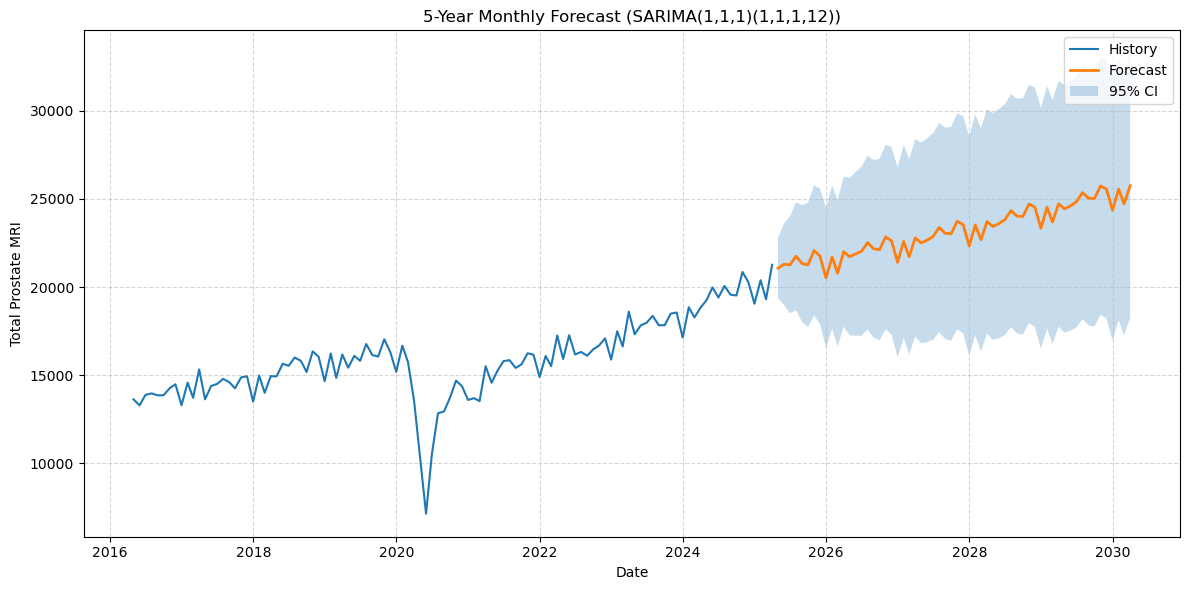

In [19]:

# 5-year monthly forecast from the cleaned series (ts_clean)
# Model: SARIMA(1,1,1)(1,1,1,12)
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Make sure the series is monthly and sorted
ts_clean = ts_clean.sort_index().asfreq('M')

# Refit model on the FULL cleaned history
final_model = sm.tsa.SARIMAX(
    ts_clean,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
).fit(disp=False)

print(final_model.summary())

# Forecast next 60 months (5 years)
h = 60
fc = final_model.get_forecast(steps=h)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()
ci_lower = fc_ci.iloc[:, 0]
ci_upper = fc_ci.iloc[:, 1]

# Collect results in a tidy DataFrame
forecast_df = pd.DataFrame({
    "Forecast": fc_mean,
    "Lower_95": ci_lower,
    "Upper_95": ci_upper
})
print(forecast_df.head())

# Save to CSV
forecast_df.to_csv("prostate_mri_forecast_5y.csv", index_label="Date")

# Plot history + forecast + 95% CI
plt.figure(figsize=(12, 6))
plt.plot(ts_clean.index, ts_clean, label="History")
plt.plot(fc_mean.index, fc_mean, label="Forecast", linewidth=2)
plt.fill_between(fc_mean.index, ci_lower, ci_upper, alpha=0.25, label="95% CI")
plt.title("5-Year Monthly Forecast (SARIMA(1,1,1)(1,1,1,12))")
plt.xlabel("Date")
plt.ylabel("Total Prostate MRI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# ==========================================
# Yearly totals from monthly forecast
# - Uses calendar years (Jan–Dec)
# - If the forecast starts mid-year, the first
#   and last years will be partial-year sums.
# ==========================================
import pandas as pd

# 0) Ensure we have a proper DateTimeIndex at monthly frequency
forecast_df = forecast_df.copy()
forecast_df.index = pd.to_datetime(forecast_df.index)
forecast_df = forecast_df.asfreq('M')  # safe if already monthly

# 1) Aggregate monthly predictions to calendar-year totals
yearly_totals = (
    forecast_df[['Forecast', 'Lower_95', 'Upper_95']]
    .resample('Y')  # calendar year (Dec year-end)
    .sum()
)

# 2) Make the index a plain "Year" column
yearly_totals.index = yearly_totals.index.year
yearly_totals.index.name = 'Year'

# 3) (Optional) Keep only full years that have all 12 forecast months
counts = forecast_df['Forecast'].resample('Y').count()
full_year_mask = counts == 12
yearly_totals_full = yearly_totals[full_year_mask.values]

# 4) Display the yearly totals
print("Yearly totals (includes partial years if present):")
display(yearly_totals)

print("\nYearly totals (full 12-month years only):")
display(yearly_totals_full)

# 5) (Optional) Save to CSV
yearly_totals.to_csv("prostate_mri_forecast_yearly_totals_all.csv", index=True)
yearly_totals_full.to_csv("prostate_mri_forecast_yearly_totals_full_years_only.csv", index=True)


Yearly totals (includes partial years if present):


/var/folders/21/0n_gt26x0cl9hz7mf2yx2n9w0000gn/T/ipykernel_2915/1571492788.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_df = forecast_df.asfreq('M')  # safe if already monthly
/var/folders/21/0n_gt26x0cl9hz7mf2yx2n9w0000gn/T/ipykernel_2915/1571492788.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample('Y')  # calendar year (Dec year-end)
/var/folders/21/0n_gt26x0cl9hz7mf2yx2n9w0000gn/T/ipykernel_2915/1571492788.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  counts = forecast_df['Forecast'].resample('Y').count()


,Forecast,Lower_95,Upper_95
Year,,,
2025,192318.188407,164132.694070,220503.682744
2026,263838.952074,206361.353389,321316.550759
2027,274218.445060,203790.499029,344646.391090
2028,285753.332884,206973.535478,364533.130290
2029,297924.249855,212244.590810,383603.908900
2030,76034.354592,53631.974757,98436.734426



Yearly totals (full 12-month years only):


,Forecast,Lower_95,Upper_95
Year,,,
2026,263838.952074,206361.353389,321316.550759
2027,274218.445060,203790.499029,344646.391090
2028,285753.332884,206973.535478,364533.130290
2029,297924.249855,212244.590810,383603.908900


In [25]:
# ==========================================
# Yearly totals from forecast (rounded to 1 decimal place, raw units)
# ==========================================
import pandas as pd

# Ensure DateTimeIndex monthly
forecast_df = forecast_df.copy()
forecast_df.index = pd.to_datetime(forecast_df.index)
forecast_df = forecast_df.asfreq('M')

# Aggregate monthly -> yearly totals
yearly_totals = (
    forecast_df[['Forecast', 'Lower_95', 'Upper_95']]
    .resample('Y')
    .sum()
)

# Index as year
yearly_totals.index = yearly_totals.index.year
yearly_totals.index.name = 'Year'

# Keep only full 12-month years
counts = forecast_df['Forecast'].resample('Y').count()
yearly_totals_full = yearly_totals[counts.values == 12]

# Round to 1 decimal place
yearly_totals      = yearly_totals.round(1)
yearly_totals_full = yearly_totals_full.round(1)

# Print in plain format (easy copy-paste into Excel)
print("Yearly totals (includes partial years):")
print(yearly_totals.to_string())

print("\nYearly totals (full 12-month years only):")
print(yearly_totals_full.to_string())

# Save to CSV for Excel use
yearly_totals.to_csv("prostate_mri_forecast_yearly_totals_all.csv", float_format="%.1f")
yearly_totals_full.to_csv("prostate_mri_forecast_yearly_totals_full_years_only.csv", float_format="%.1f")


Yearly totals (includes partial years):
      Forecast  Lower_95  Upper_95
Year                              
2025  192318.2  164132.7  220503.7
2026  263839.0  206361.4  321316.6
2027  274218.4  203790.5  344646.4
2028  285753.3  206973.5  364533.1
2029  297924.2  212244.6  383603.9
2030   76034.4   53632.0   98436.7

Yearly totals (full 12-month years only):
      Forecast  Lower_95  Upper_95
Year                              
2026  263839.0  206361.4  321316.6
2027  274218.4  203790.5  344646.4
2028  285753.3  206973.5  364533.1
2029  297924.2  212244.6  383603.9


/var/folders/21/0n_gt26x0cl9hz7mf2yx2n9w0000gn/T/ipykernel_2915/4263337929.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_df = forecast_df.asfreq('M')
/var/folders/21/0n_gt26x0cl9hz7mf2yx2n9w0000gn/T/ipykernel_2915/4263337929.py:14: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample('Y')
/var/folders/21/0n_gt26x0cl9hz7mf2yx2n9w0000gn/T/ipykernel_2915/4263337929.py:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  counts = forecast_df['Forecast'].resample('Y').count()


In [27]:
# Sum of Total Prostate MRI for calendar year 2024
prostate_yearly = ts_clean.resample('Y').sum()

# Extract 2024
total_2024 = prostate_yearly.loc['2024'].values[0]
print(f"Total Prostate MRI count in 2024: {total_2024:,.1f}")


Total Prostate MRI count in 2024: 233,953.0


/var/folders/21/0n_gt26x0cl9hz7mf2yx2n9w0000gn/T/ipykernel_2915/500651247.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  prostate_yearly = ts_clean.resample('Y').sum()
